In [1]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
from pathlib import Path
import time
import re, subprocess
import pandas as pd
from datetime import datetime

import tools21cm as t2c

import TCF_Class

## check contents of h5 file

In [2]:
path = '/data/cluster/lcrascal/SIM_data/sim_data_h5_files_clean/Lightcone_FID_400_Samples.h5'
path = '/data/cluster/lcrascal/SIM_data/mock_tests/Mock_SIM_1/Lightcone_MOCK_1.h5'
path = '/data/cluster/lcrascal/SIM_data/mock_tests/Mock_SIM_1/Lightcone_MOCK_1_NOISE.h5'


def list_h5_contents(path):
    with h5py.File(path, "r") as f:
        def show(name, obj):
            if isinstance(obj, h5py.Group):
                print(f"[GROUP]   /{name}")
                if obj.attrs:
                    for k, v in obj.attrs.items():
                        print(f"          ‚îî‚îÄ attr {k!r}: {v}")
            elif isinstance(obj, h5py.Dataset):
                print(f"[DATASET] /{name}  shape={obj.shape}  dtype={obj.dtype}")
                if obj.attrs:
                    for k, v in obj.attrs.items():
                        print(f"          ‚îî‚îÄ attr {k!r}: {v}")
        f.visititems(show)

# usage
list_h5_contents(path)

#with h5py.File(path, "r") as f:
    #print(f['redshifts'][0])
    #print(f['redshifts'][-1])
    #print(f['box_length'][...])
    #print(f['redshifts'][:])
    #print(f['redshifts_used'][:])

# redshift[0] = 9.33 closer to big bang
# redshift [-1] = 8.82 closer to now

[DATASET] /box_length  shape=(1,)  dtype=float64
[DATASET] /brightness_lightcone  shape=(3, 128, 256, 256)  dtype=float32
          ‚îî‚îÄ attr 'axis_order': n_real, z, x, y
[DATASET] /frequencies  shape=(128,)  dtype=float64
[DATASET] /ngrid  shape=(1,)  dtype=int64
[DATASET] /nrealisations  shape=(1,)  dtype=int64
[DATASET] /redshifts  shape=(128,)  dtype=float64
[DATASET] /redshifts_used  shape=(128,)  dtype=float64


# Compute Statistic TCF Pipeline

## Extract z slices from sim function

In [3]:
import os
import h5py
import numpy as np
from pathlib import Path

def extract_SIM_z_slices_to_txtfiles(h5_filepath, output_dir, z_indices):
    """
    Extract 2D slices at specified z-indices and save each realisation as .txt
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    with h5py.File(h5_filepath, 'r') as f:
        ds = f['brightness_lightcone']

        # Infer dims
        if ds.ndim == 4:                    # (n_realisations, z, y, x)
            n_realisations, n_freq = ds.shape[0], ds.shape[1]
        elif ds.ndim == 3:                  # (z, y, x) ‚Äî single realisation
            n_realisations, n_freq = 1, ds.shape[0]
        else:
            raise ValueError(f"Unexpected ndim={ds.ndim}; expected 3 or 4.")

        # Normalize input
        if z_indices is None:
            z_indices = list(range(n_freq))
        elif isinstance(z_indices, int):
            z_indices = [z_indices]
        else:
            z_indices = list(z_indices)

        saved_dirs = []

        for z_idx in z_indices:
            if not (0 <= z_idx < n_freq):
                raise ValueError(f"z_idx {z_idx} out of bounds [0, {n_freq-1}]")

            # Create the per-z subfolder 
            output_folder = output_dir / f"Lightcone_zidx{z_idx}"
            output_folder.mkdir(parents=True, exist_ok=True)

            print(f"\nExtracting slices for z_idx={z_idx} -> {output_folder}")

            if ds.ndim == 4:
                for i in range(n_realisations):
                    slice_2d = ds[i, z_idx, :, :]
                    np.savetxt(output_folder / f"realisation_{i}.txt", slice_2d)
            else:
                slice_2d = ds[z_idx, :, :]
                np.savetxt(output_folder / "realisation_0.txt", slice_2d)

            print(f"  ‚úî Saved {n_realisations} slice(s) for z_idx={z_idx}")
            saved_dirs.append(str(output_folder))

    return saved_dirs


In [4]:
# example usage

# mock_h5_filepath = '/data/cluster/lcrascal/SIM_data/h5_files/mock_tests/Lightcone_MOCK.h5'
# output_dir = '/data/cluster/lcrascal/SIM_data/h5_files/mock_tests/mock_txtfiles/'

# zrange = np.linspace(0, 12, 13, dtype=int)
# extract_SIM_z_slices_to_txtfiles(mock_h5_filepath, output_dir, z_indices=zrange)




## add noise and smoothing to a simulation

### new version

In [12]:
import os, h5py, numpy as np
from pathlib import Path

def add_noise_and_smooth_all_realisations(
    clean_h5_file,
    *,
    obs_time,
    total_int_time,
    int_time,
    declination,
    subarray_type,
    verbose,
    save_uvmap,
    njobs,
    checkpoint,
    bmax_km
):
    """
    From a clean lightcone H5 (n_real, z, x, y), produce:
      <stem>_NOISE_ONLY_LC.h5          (noise-only)
      <stem>_NOISE.h5                  (clean + noise)
      <stem>_NOISE_SMOOTHING.h5        (subtract LOS-mean(clean) + noise, then smooth)
    All saved in canonical (n_real, z, x, y). Each output also stores 'redshifts_used'
    which matches any flip performed internally by smooth_lightcone.

    Notes:
    - t2c.noise_lightcone returns (x,y,z)
    - t2c.smooth_lightcone expects (x,y,z) and returns (x,y,z) with a possible axis-2 flip
      if input redshifts are decreasing. It returns the redshifts it used as the 2nd value.
    """

    # ---- helpers to convert per-realisation views ----
    def zxy_to_xyz(a):  # (z,x,y) -> (x,y,z)
        return np.moveaxis(a, 0, 2)

    def xyz_to_zxy(a):  # (x,y,z) -> (z,x,y)
        return np.moveaxis(a, 2, 0)

    clean_h5_file = Path(clean_h5_file).resolve()
    out_dir = clean_h5_file.parent  # directory 
    stem    = clean_h5_file.stem

    # target H5 paths
    noiseonly_out = out_dir / f"{stem}_NOISE_ONLY_LC.h5"
    noisy_out     = out_dir / f"{stem}_NOISE.h5"
    obs_out       = out_dir / f"{stem}_NOISE_SMOOTHING.h5"

    print("Starting SKA noise + smoothing for all realisations")
    print(f"Input:  {clean_h5_file.name}")
    print(f"Will create output: {noiseonly_out.name}, {noisy_out.name}, {obs_out.name}")

    # ---- read metadata once ----
    with h5py.File(clean_h5_file, 'r') as f:
        redshifts   = f['redshifts'][...]
        frequencies = f['frequencies'][...]
        box_length  = float(f['box_length'][...].squeeze())
        box_dim     = int(np.array(f['ngrid'][...]).squeeze())
        ds          = f['brightness_lightcone']      # (n_real, z, x, y)
        n_real, n_z, ny, nx = ds.shape
        assert ny == nx == box_dim, f"Shape mismatch: {ds.shape} vs box_dim={box_dim}"
        print(f"Header: n_real={n_real}, n_z={n_z}, DIM={box_dim}")

    # ---- UV map path ----
    uvpath = Path(save_uvmap)
    uvpath.parent.mkdir(parents=True, exist_ok=True)
    print(f"{'Reusing' if uvpath.exists() else 'Will save'} UV map at: {uvpath}")

    # ---- small factory to build output files ----
    def create_out(path):
        fout = h5py.File(path, 'w')
        fout.create_dataset("redshifts", data=redshifts)
        fout.create_dataset("frequencies", data=frequencies)
        fout.create_dataset("box_length", data=np.array([box_length], dtype=np.float64))
        fout.create_dataset("ngrid", data=np.array([box_dim], dtype=np.int64))
        fout.create_dataset("nrealisations", data=np.array([n_real], dtype=np.int64))
        dset = fout.create_dataset(
            "brightness_lightcone",
            shape=(n_real, n_z, box_dim, box_dim),
            dtype=np.float32,
            chunks=True,
            compression="gzip",
            compression_opts=4,
        )
        dset.attrs["axis_order"] = "n_real, z, x, y"
        # we'll store the actually used redshifts (may be flipped by t2c) here:
        rz = fout.create_dataset("redshifts_used", shape=(n_z,), dtype=redshifts.dtype)
        return fout, dset, rz

    f_noise, d_noise, rz_noise = create_out(noiseonly_out)
    f_noisy, d_noisy, rz_noisy = create_out(noisy_out)
    f_obs,   d_obs,   rz_obs   = create_out(obs_out)

    try:
        # set redshifts_used defaults to input; may be overwritten after a call to smooth_lightcone
        rz_noise[...] = redshifts
        rz_noisy[...] = redshifts
        rz_obs  [...] = redshifts

        with h5py.File(clean_h5_file, 'r') as f:
            ds = f['brightness_lightcone']  # (n_real, z, x, y)

            for i in range(n_real):
                # if i % 10 == 0:
                print(f" ‚û§ Realisation {i+1}/{n_real}")

                # (z,x,y) for a single realisation
                clean_zxy = ds[i, ...]
                # convert to (x,y,z) for t2c
                clean_xyz = zxy_to_xyz(clean_zxy)  # (x,y,z)

                # --- noise (x,y,z) ---
                noise_xyz = t2c.noise_lightcone(
                    ncells=box_dim,
                    zs=redshifts,
                    obs_time=obs_time,
                    total_int_time=total_int_time,
                    int_time=int_time,
                    declination=declination,
                    subarray_type=subarray_type,
                    boxsize=box_length,
                    verbose=verbose,
                    save_uvmap=str(uvpath),
                    n_jobs=njobs,
                    checkpoint=checkpoint,
                )

                # basic shape guard (common mistake: zxy instead of xyz)
                if noise_xyz.shape != (box_dim, box_dim, n_z):
                    if noise_xyz.shape == (n_z, box_dim, box_dim):
                        noise_xyz = zxy_to_xyz(noise_xyz)
                    else:
                        raise ValueError(f"Unexpected noise shape {noise_xyz.shape}; expected (x,y,z)=({box_dim},{box_dim},{n_z})")

                # write noise-only as (z,x,y)
                d_noise[i, ...] = xyz_to_zxy(noise_xyz)

                # --- noisy = clean + noise (still xyz) ---
                noisy_xyz = (clean_xyz + noise_xyz).astype(np.float32)
                d_noisy[i, ...] = xyz_to_zxy(noisy_xyz)

                # --- observed: subtract LOS-mean(clean), add noise, smooth ---
                # smooth_lightcone expects (x,y,z), treats axis=2 as z,
                # returns (x,y,z) and redshifts_used (possibly flipped)
                obs_xyz, rz_used = t2c.smooth_lightcone(
                    lightcone=noise_xyz + t2c.subtract_mean_signal(clean_xyz, los_axis=2),
                    z_array=redshifts,
                    box_size_mpc=box_length,
                    max_baseline=bmax_km,
                )
                obs_xyz = obs_xyz.astype(np.float32)

                # check correct redshift used
                if (rz_used.shape != redshifts.shape) or (not np.array_equal(rz_used, redshifts)):
                    raise RuntimeError(
                        "smooth_lightcone returned a different redshift grid than provided."
                        "This usually means the function flipped the LOS because "
                        "your input redshifts were decreasing. Ensure input redshifts are strictly "
                        "increasing and try again."
                    )

                # sanity on shape
                if obs_xyz.shape != (box_dim, box_dim, n_z):
                    if obs_xyz.shape == (n_z, box_dim, box_dim):
                        obs_xyz = zxy_to_xyz(obs_xyz)
                    else:
                        raise ValueError(f"Unexpected smoothed shape {obs_xyz.shape}")

                # write observed back as (z,x,y), record the z grid actually used
                d_obs[i, ...] = xyz_to_zxy(obs_xyz)
                rz_obs[...]   = redshifts  # same for all realisations for a given input; OK to overwrite

                # check things are working sensibly
                assert np.allclose(noisy_xyz - clean_xyz, noise_xyz, atol=1e-5), \
                    "Noisy - Clean != Noise-only (something is inconsistent!)"


    finally:
        f_noise.close()
        f_noisy.close()
        f_obs.close()

    print("All realisations processed and saved.")
    return {
        "noise_only_h5": str(noiseonly_out),
        "noisy_h5": str(noisy_out),
        "observed_h5": str(obs_out)
    }


In [24]:
# testing

# --- parameters --- #
# 1.  AAstar, 1000hrs 
obs_time = 1000.                       # total observation hours
total_int_time = 6.                   # hours per day
int_time = 10.                        # seconds
declination = -30.0                   # declination of the field in degrees
subarray_type = "AA4"
bmax_km = 2. #* units.km # km

verbose = False
save_uvmap = "/data/cluster/lcrascal/uvmaps/uvmap_AA4_1000hrs.h5"
njobs = 1
checkpoint = 16


# --- test inputs ---¬†#
mock_clean = '/data/cluster/lcrascal/SIM_data/mock_tests/Mock_SIM_1/Lightcone_MOCK_1.h5'


out_paths = add_noise_and_smooth_all_realisations(
    clean_h5_file=mock_clean,
    obs_time=obs_time,            # fake parameters just for test
    total_int_time=total_int_time,
    int_time=int_time,
    declination=declination,
    subarray_type=subarray_type,
    verbose=verbose,
    save_uvmap=save_uvmap,
    njobs=njobs,
    checkpoint=checkpoint,
    bmax_km=bmax_km,
)

print("\nOutputs created:")
for k, v in out_paths.items():
    print(f"  {k}: {v}")

# --- verify outputs ---
for key in ["noise_only_h5", "noisy_h5", "observed_h5"]:
    path = Path(out_paths[key])
    print(f"\n File Name: {path.name}")
    with h5py.File(path, "r") as f:
        for dsname in ["brightness_lightcone", "redshifts", "frequencies", "ngrid"]:
            assert dsname in f, f"{dsname} missing from {path.name}"
        arr = f["brightness_lightcone"]
        print(f" shape={arr.shape}, dtype={arr.dtype}")
        # quick sample statistics for the first realisation
        sample = arr[0]
        print("  sample stats:",
              f"min={np.nanmin(sample):.3g}, max={np.nanmax(sample):.3g}, mean={np.nanmean(sample):.3g}")


Starting SKA noise + smoothing for all realisations
Input:  Lightcone_MOCK_1.h5
Will create output: Lightcone_MOCK_1_NOISE_ONLY_LC.h5, Lightcone_MOCK_1_NOISE.h5, Lightcone_MOCK_1_NOISE_SMOOTHING.h5
Header: n_real=3, n_z=128, DIM=256
Reusing UV map at: /data/cluster/lcrascal/uvmaps/uvmap_AA4_1000hrs.h5
 ‚û§ Realisation 1/3
Creating noise lightcone...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 128/128 [00:00<00:00, 175.29it/s]


 ‚û§ Realisation 2/3
Creating noise lightcone...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 128/128 [00:00<00:00, 175.50it/s]


 ‚û§ Realisation 3/3
Creating noise lightcone...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 128/128 [00:00<00:00, 132.01it/s]


All realisations processed and saved.

Outputs created:
  noise_only_h5: /data/cluster/lcrascal/SIM_data/mock_tests/Mock_SIM_1/Lightcone_MOCK_1_NOISE_ONLY_LC.h5
  noisy_h5: /data/cluster/lcrascal/SIM_data/mock_tests/Mock_SIM_1/Lightcone_MOCK_1_NOISE.h5
  observed_h5: /data/cluster/lcrascal/SIM_data/mock_tests/Mock_SIM_1/Lightcone_MOCK_1_NOISE_SMOOTHING.h5

 File Name: Lightcone_MOCK_1_NOISE_ONLY_LC.h5
 shape=(3, 128, 256, 256), dtype=float32
  sample stats: min=-3.59e+03, max=3.82e+03, mean=0.003

 File Name: Lightcone_MOCK_1_NOISE.h5
 shape=(3, 128, 256, 256), dtype=float32
  sample stats: min=-3.57e+03, max=3.83e+03, mean=19.4

 File Name: Lightcone_MOCK_1_NOISE_SMOOTHING.h5
 shape=(3, 128, 256, 256), dtype=float32
  sample stats: min=-47.6, max=42.9, mean=-0.00474


{'noise_only_h5': '/data/cluster/lcrascal/SIM_data/mock_tests/Mock_SIM_1/Lightcone_MOCK_1_NOISE_ONLY_LC.h5', 'noisy_h5': '/data/cluster/lcrascal/SIM_data/mock_tests/Mock_SIM_1/Lightcone_MOCK_1_NOISE.h5', 'observed_h5': '/data/cluster/lcrascal/SIM_data/mock_tests/Mock_SIM_1/Lightcone_MOCK_1_NOISE_SMOOTHING.h5'}


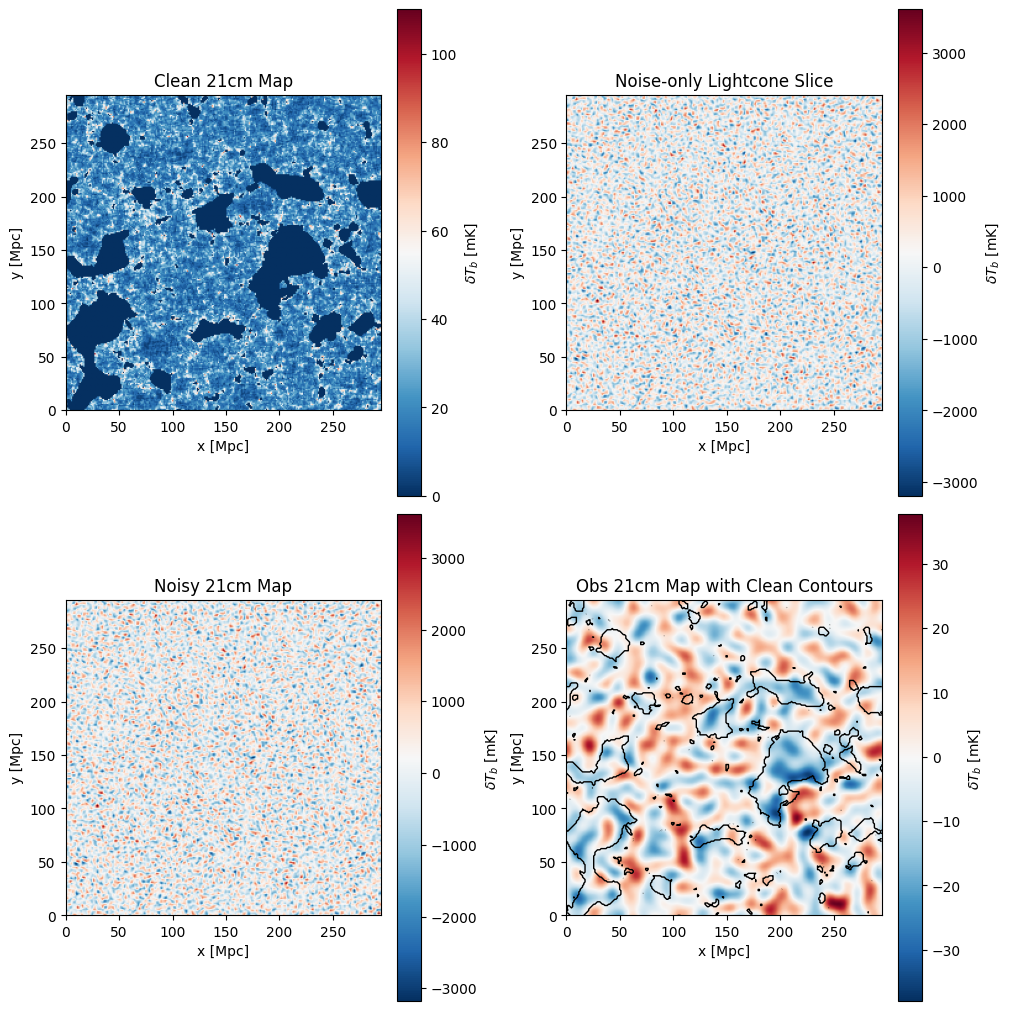

In [25]:
import numpy as np
import matplotlib.pyplot as plt

print(out_paths)
with h5py.File('/data/cluster/lcrascal/SIM_data/mock_tests/Mock_SIM_1/Lightcone_MOCK_1.h5', "r") as f:
    slice2D_clean = f['brightness_lightcone'][0, 0, :, :]

with h5py.File('/data/cluster/lcrascal/SIM_data/mock_tests/Mock_SIM_1/Lightcone_MOCK_1_NOISE_ONLY_LC.h5', "r") as f:
    slice2D_noiseonly = f['brightness_lightcone'][0, 0, :, :]

with h5py.File('/data/cluster/lcrascal/SIM_data/mock_tests/Mock_SIM_1/Lightcone_MOCK_1_NOISE.h5', "r") as f:
    slice2D_noisy = f['brightness_lightcone'][0, 0, :, :]

with h5py.File('/data/cluster/lcrascal/SIM_data/mock_tests/Mock_SIM_1/Lightcone_MOCK_1_NOISE_SMOOTHING.h5', "r") as f:
    slice2D_obs = f['brightness_lightcone'][0, 0, :, :]



# assume these exist and all have shape (Ny, Nx) with the same L:
# slice2D_clean, slice2D_noiseonly, slice2D_noisy, slice2D_obs
# and L is the box size in Mpc (e.g., L = 295)

L = float(295)  # ensure it's a float
extent = (0, L, 0, L)

fig, axes = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
axs = axes.ravel()

def show(ax, img, title):
    im = ax.imshow(img, origin='lower', extent=extent, cmap='RdBu_r')
    ax.set_xlabel('x [Mpc]')
    ax.set_ylabel('y [Mpc]')
    ax.set_title(title)
    plt.colorbar(im, ax=ax, label=r'$\delta T_b$ [mK]')
    return im

# 1) clean
show(axs[0], slice2D_clean, 'Clean 21cm Map')

# 2) noise only
show(axs[1], slice2D_noiseonly, 'Noise-only Lightcone Slice')

# 3) noisy = clean + noise
show(axs[2], slice2D_noisy, 'Noisy 21cm Map')

# 4) observed (noise + smoothing) + overlay contours from clean
show(axs[3], slice2D_obs, 'Obs 21cm Map with Clean Contours')
ny, nx = slice2D_clean.shape
x = np.linspace(0, L, nx)
y = np.linspace(0, L, ny)
# choose contour levels (example: 3 quantiles of the clean map)
levels = [1e-4]
axs[3].contour(x, y, slice2D_clean, levels=levels, colors='black', linewidths=1.0)

plt.show()





[Clean]
  mean=17.74, std=13.74, skew=0.8743, kurtosis(excess)=1.3
  median=16.44, IQR=15.9 (Q25=9.49, Q75=25.39)
  min=0, max=110

[Noise-only]
  mean=0.6565, std=756.2, skew=-0.004813, kurtosis(excess)=0.0007412
  median=4, IQR=1020 (Q25=-508.8, Q75=511.7)
  min=-3195, max=3604

[Noisy]
  mean=18.4, std=756.3, skew=-0.004728, kurtosis(excess)=-0.0002205
  median=21.5, IQR=1022 (Q25=-491.3, Q75=530.5)
  min=-3178, max=3604

[Observed (Noise+Smoothing)]
  mean=-0.5228, std=10.78, skew=0.01021, kurtosis(excess)=0.001743
  median=-0.5897, IQR=14.68 (Q25=-7.877, Q75=6.801)
  min=-37.98, max=37.71


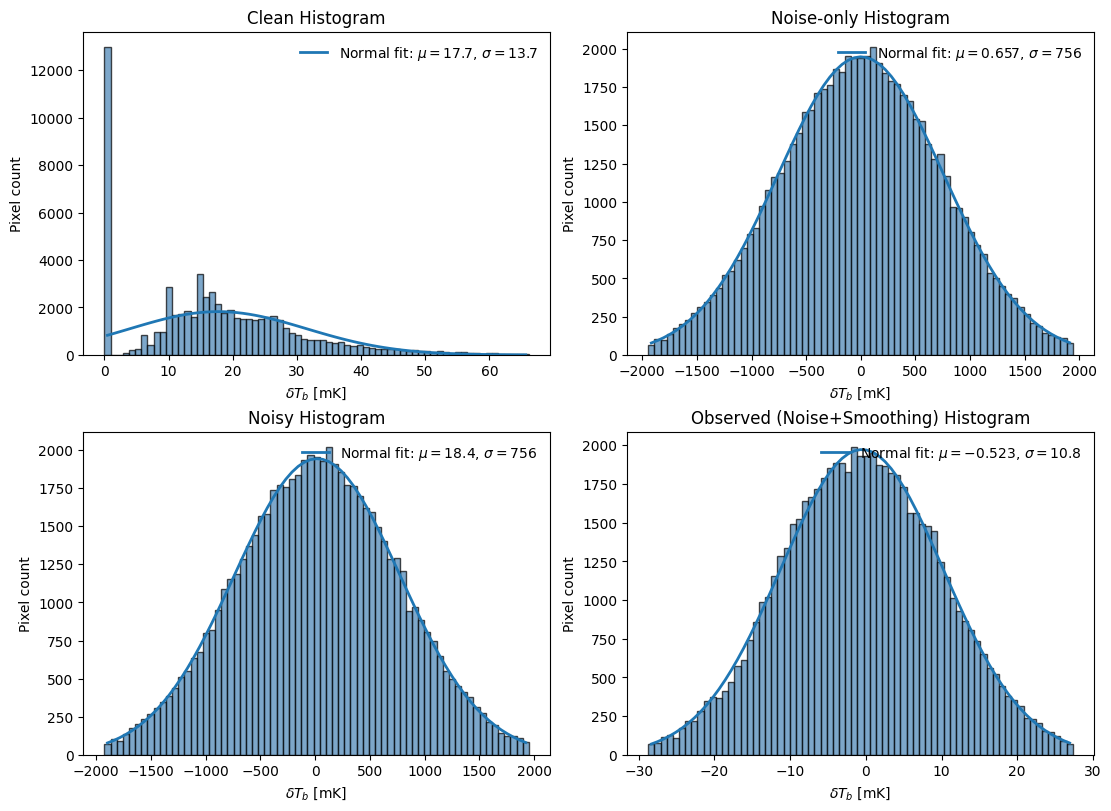

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats  # needs scipy installed

# flatten all maps into 1D arrays for histogramming
maps = {
    "Clean": slice2D_clean.ravel(),
    "Noise-only": slice2D_noiseonly.ravel(),
    "Noisy": slice2D_noisy.ravel(),
    "Observed (Noise+Smoothing)": slice2D_obs.ravel(),
}

fig, axes = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=True)
axs = axes.ravel()

def print_stats(title, x):
    mean  = np.mean(x)
    std   = np.std(x, ddof=1)
    skew  = stats.skew(x, bias=False, nan_policy="omit")
    kurt  = stats.kurtosis(x, fisher=True, bias=False, nan_policy="omit")  # 0 for perfect normal
    med   = np.median(x)
    q25, q75 = np.percentile(x, [25, 75])
    iqr   = q75 - q25
    xmin, xmax = np.min(x), np.max(x)
    print(f"\n[{title}]")
    print(f"  mean={mean:.4g}, std={std:.4g}, skew={skew:.4g}, kurtosis(excess)={kurt:.4g}")
    print(f"  median={med:.4g}, IQR={iqr:.4g} (Q25={q25:.4g}, Q75={q75:.4g})")
    print(f"  min={xmin:.4g}, max={xmax:.4g}")

for ax, (title, data) in zip(axs, maps.items()):
    # robust range per panel
    vmin, vmax = np.percentile(data, [0.5, 99.5])
    bins = np.linspace(vmin, vmax, 70)

    # histogram
    counts, edges, _ = ax.hist(
        data, bins=bins, color='steelblue', alpha=0.7, edgecolor='k'
    )

    # fit normal (mu, sigma)
    mu_hat, sigma_hat = stats.norm.fit(data)

    # overlay fitted normal scaled to histogram counts
    centers = 0.5 * (edges[:-1] + edges[1:])
    bin_width = edges[1] - edges[0]
    pdf = stats.norm.pdf(centers, loc=mu_hat, scale=sigma_hat)   # density
    y_fit = pdf * data.size * bin_width                          # scale to counts
    ax.plot(centers, y_fit, lw=2, label=fr"Normal fit: $\mu={mu_hat:.3g}$, $\sigma={sigma_hat:.3g}$")

    # cosmetics
    ax.set_title(f"{title} Histogram")
    ax.set_xlabel(r'$\delta T_b$ [mK]')
    ax.set_ylabel("Pixel count")
    ax.legend(loc="best", frameon=False)

    # print stats to console
    print_stats(title, data)

plt.show()


In [16]:
def add_noise_and_smooth_all_realisations_old(
    clean_h5_file,
    noisy_output_h5_file,
    obs_output_h5_file,
    noise_only_output_h5_file,
    obs_time,
    total_int_time,
    int_time,
    declination,
    subarray_type,
    verbose,
    save_uvmap,
    njobs,
    checkpoint,
    bmax_km
):
    print("Starting full SKA noise simulation for all realisations")

    # Load clean sim
    with h5py.File(clean_h5_file, 'r') as f:
        redshifts = f['redshifts'][...]
        box_length = float(f['box_length'][0])
        box_dim = int(f['ngrid'][0])
        frequencies = f['frequencies'][...]
        clean_all = f['brightness_lightcone'][...]  # shape: (n_realisations, z, x, y)
        n_realisations = clean_all.shape[0]

    print(f"Loaded clean lightcone: {n_realisations} realisations of shape {clean_all.shape[1:]}")

    # Prepare output arrays
    noisy_all = np.zeros((n_realisations, box_dim, box_dim, len(redshifts)), dtype=np.float32)
    obs_all = np.zeros_like(noisy_all)
    noise_all = np.zeros_like(noisy_all)

    # Only generate and reuse UV map if not already present
    if os.path.exists(save_uvmap):
        print(f"Reusing existing UV map: {save_uvmap}")
    else:
        print(f"Will save UV map to: {save_uvmap}")

    print("Looping over realisations...")

    for i in range(n_realisations):
        #if i % 10 == 0:
        print(f" ‚û§ Processing realisation {i + 1} / {n_realisations}")

        # Move clean realisation to (x, y, z)
        clean = np.moveaxis(clean_all[i], 0, 2)  # from (z, x, y) to (x, y, z)

        # Generate a new noise lightcone for this realisation
        noise_lc = t2c.noise_lightcone(
            ncells=box_dim,
            zs=redshifts,
            obs_time=obs_time,
            total_int_time=total_int_time,
            int_time=int_time,
            declination=declination,
            subarray_type=subarray_type,
            boxsize=box_length,
            verbose=verbose,
            save_uvmap=save_uvmap,
            n_jobs=njobs,
            checkpoint=checkpoint,
        )  # shape: (box_dim, box_dim, len(z))

        noise_all[i] = noise_lc

        # Add noise
        noisy = clean + noise_lc
        noisy_all[i] = noisy

        # Smooth (subtract mean first!)
        smoothed = t2c.smooth_lightcone(
            lightcone=noise_lc + t2c.subtract_mean_signal(clean, los_axis=2),
            z_array=redshifts,
            box_size_mpc=box_length,
            max_baseline=bmax_km,
        )[0]  # (x, y, z)
        obs_all[i] = smoothed

    # Save noise-only lightcones
    print(f"Saving all noise-only lightcones ‚Üí {noise_only_output_h5_file}")
    with h5py.File(noise_only_output_h5_file, 'w') as fout:
        fout.create_dataset("brightness_lightcone", data=noise_all)
        fout.create_dataset("redshifts", data=redshifts)
        fout.create_dataset("frequencies", data=frequencies)
        fout.create_dataset("box_length", data=np.array([box_length]))
        fout.create_dataset("ngrid", data=np.array([box_dim]))
        fout.create_dataset("nrealisations", data=np.array([n_realisations]))

    # Save noisy lightcones
    print(f"Saving noisy lightcones ‚Üí {noisy_output_h5_file}")
    with h5py.File(noisy_output_h5_file, 'w') as fout:
        fout.create_dataset("brightness_lightcone", data=noisy_all)
        fout.create_dataset("redshifts", data=redshifts)
        fout.create_dataset("frequencies", data=frequencies)
        fout.create_dataset("box_length", data=np.array([box_length]))
        fout.create_dataset("ngrid", data=np.array([box_dim]))
        fout.create_dataset("nrealisations", data=np.array([n_realisations]))

    # Save observed (smoothed) lightcones
    print(f"Saving smoothed lightcones ‚Üí {obs_output_h5_file}")
    with h5py.File(obs_output_h5_file, 'w') as fout:
        fout.create_dataset("brightness_lightcone", data=obs_all)
        fout.create_dataset("redshifts", data=redshifts)
        fout.create_dataset("frequencies", data=frequencies)
        fout.create_dataset("box_length", data=np.array([box_length]))
        fout.create_dataset("ngrid", data=np.array([box_dim]))
        fout.create_dataset("nrealisations", data=np.array([n_realisations]))

    print("All realisations processed and saved.")


In [28]:
# testing old


# --- parameters --- #
# 1.  AAstar, 1000hrs 
obs_time = 1000.                      # total observation hours
total_int_time = 6.                   # hours per day
int_time = 10.                        # seconds
declination = -30.0                   # declination of the field in degrees
subarray_type = "AA4"

verbose = True
save_uvmap = "/data/cluster/lcrascal/uvmaps/uvmap_AA4_1000hrs.h5"
njobs = 1
checkpoint = 16
bmax_km = 2. #* units.km # km


clean_h5_file = '/data/cluster/lcrascal/SIM_data/mock_tests/Mock_SIM_1/Lightcone_MOCK_1.h5'
noisy_output_h5_file = '/data/cluster/lcrascal/SIM_data/mock_tests/Mock_SIM_1/check_noisy.h5'
obs_output_h5_file = '/data/cluster/lcrascal/SIM_data/mock_tests/Mock_SIM_1/check_obs.h5'
noise_only_output_h5_file = '/data/cluster/lcrascal/SIM_data/mock_tests/Mock_SIM_1/check_noise_only.h5'

add_noise_and_smooth_all_realisations_old(
    clean_h5_file,
    noisy_output_h5_file,
    obs_output_h5_file,
    noise_only_output_h5_file,
    obs_time,
    total_int_time,
    int_time,
    declination,
    subarray_type,
    verbose,
    save_uvmap,
    njobs,
    checkpoint,
    bmax_km
)

Starting full SKA noise simulation for all realisations
Loaded clean lightcone: 3 realisations of shape (128, 256, 256)
Reusing existing UV map: /data/cluster/lcrascal/uvmaps/uvmap_AA4_1000hrs.h5
Looping over realisations...
 ‚û§ Processing realisation 1 / 3
AA4 contains 512 antennae.
ENU -> ECEF -> XYZ
Loading existing UV maps from /data/cluster/lcrascal/uvmaps/uvmap_AA4_1000hrs.h5
All requested redshift UV maps are already present.
Creating noise lightcone...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 128/128 [00:01<00:00, 76.20it/s]


 ‚û§ Processing realisation 2 / 3
AA4 contains 512 antennae.
ENU -> ECEF -> XYZ
Loading existing UV maps from /data/cluster/lcrascal/uvmaps/uvmap_AA4_1000hrs.h5
All requested redshift UV maps are already present.
Creating noise lightcone...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 128/128 [00:01<00:00, 102.97it/s]


 ‚û§ Processing realisation 3 / 3
AA4 contains 512 antennae.
ENU -> ECEF -> XYZ
Loading existing UV maps from /data/cluster/lcrascal/uvmaps/uvmap_AA4_1000hrs.h5
All requested redshift UV maps are already present.
Creating noise lightcone...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 128/128 [00:01<00:00, 79.24it/s]


Saving all noise-only lightcones ‚Üí /data/cluster/lcrascal/SIM_data/mock_tests/Mock_SIM_1/check_noise_only.h5
Saving noisy lightcones ‚Üí /data/cluster/lcrascal/SIM_data/mock_tests/Mock_SIM_1/check_noisy.h5
Saving smoothed lightcones ‚Üí /data/cluster/lcrascal/SIM_data/mock_tests/Mock_SIM_1/check_obs.h5
All realisations processed and saved.


cube_shape (3, 256, 256, 128)


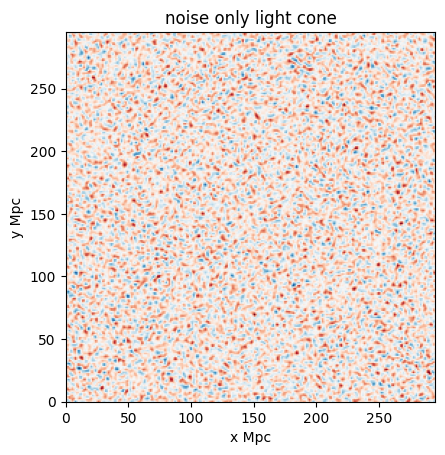

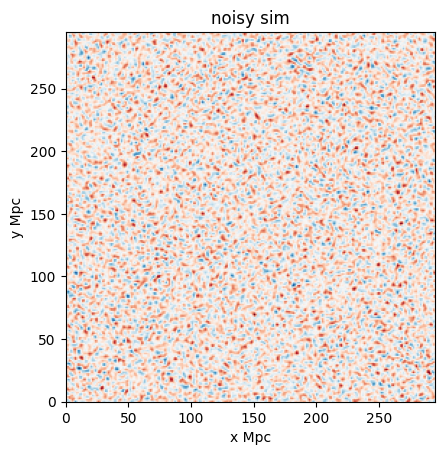

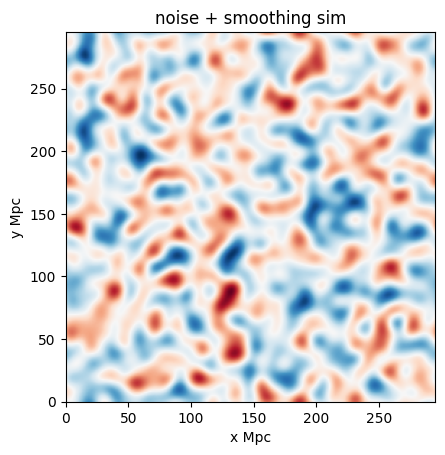

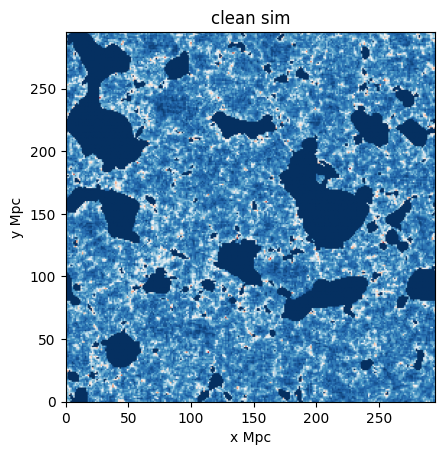

In [34]:
noise_only_h5 = noise_only_output_h5_file
noisy_h5 = noisy_output_h5_file
observed_h5 = obs_output_h5_file


with h5py.File(noise_only_h5, "r") as f:
    slice2D_noiseonly = f['brightness_lightcone'][0, :, :, 0]

with h5py.File(noisy_h5, "r") as f:
    slice2D_noisy = f['brightness_lightcone'][0, :, :, 0]

with h5py.File(observed_h5, "r") as f:
    slice2D_obs = f['brightness_lightcone'][0, :, :, 0]
    cube_shape = np.shape(f['brightness_lightcone'][...])
    print("cube_shape", cube_shape)

with h5py.File(clean_h5_file, "r") as f:
    slice2D_clean = f['brightness_lightcone'][0, 0, :, :]
    
            

L = 295
plt.imshow((slice2D_noiseonly), extent=(0, L, 0, L), cmap="RdBu_r")
plt.xlabel('x Mpc')
plt.ylabel('y Mpc')
plt.title('noise only light cone')
plt.show()

plt.imshow((slice2D_noisy), extent=(0, L, 0, L), cmap="RdBu_r")
plt.xlabel('x Mpc')
plt.ylabel('y Mpc')
plt.title('noisy sim')
plt.show()

plt.imshow((slice2D_obs), extent=(0, L, 0, L), cmap="RdBu_r")
plt.xlabel('x Mpc')
plt.ylabel('y Mpc')
plt.title('noise + smoothing sim')
plt.show()

plt.imshow((slice2D_clean), extent=(0, L, 0, L), cmap="RdBu_r")
plt.xlabel('x Mpc')
plt.ylabel('y Mpc')
plt.title('clean sim')
plt.show()

## compute TCF of all realisations for a single sim

In [8]:
import os, re, time, h5py, numpy as np
from pathlib import Path


def compute_TCF_of_single_SIM_all_realisations(
    sim_filepath,
    z_indices=0,
    *,
    tcf_code_dir,
    nthreads=5,
    nbins=100,
    rmin=3,
    rmax=60.0,
    overwrite_h5=True,        # overwrite H5 datasets
    overwrite_txt=False,      # re-extract .txt even if already present
    continue_on_error=False   # skip bad realisations instead of raising
):

    h = 0.6774
    
    sim_filepath = Path(sim_filepath).resolve()
    sim_dir = sim_filepath.parent
    sim_stem = sim_filepath.stem

    # Create txt folder for this sim
    txt_root = sim_dir / f"{sim_stem}_txtfiles"
    txt_root.mkdir(parents=True, exist_ok=True)
    print(f"üìÇ TXT files will be stored in: {txt_root}")


    # --- read sim metadata once --- #
    with h5py.File(sim_filepath, "r") as f:
        ds = f["brightness_lightcone"]
        assert ds.ndim == 4, f"Expected 4D lightcone, got {ds.ndim}D with shape {ds.shape}"
        n_real, n_freq, ny, nx = ds.shape
        assert ny == nx, f"Expected square x‚Äìy plane; got {ny}√ó{nx}"
        if "frequencies" in f:
            assert f["frequencies"].shape[0] == n_freq
        if "redshifts" in f:
            assert f["redshifts"].shape[0] == n_freq
        L_Mpc_perh = float(f["box_length"][...].squeeze()) #
        L = L_Mpc_perh/h # Mpc
        DIM = int(nx)
        print("L:", L)
        print("DIM:", DIM)

    # normalize z_indices 
    if z_indices is None:                            # case for all z slices in sim
        z_indices = list(range(n_freq))
    elif isinstance(z_indices, (int, np.integer)):   # case for only a single z slice
        z_indices = [int(z_indices)]
    else:                                            # case for a subset of z slices in sim
        z_indices = [int(z) for z in z_indices]

    # --- extract slices to txtfiles --- #
    # Only extract if overwrite_txt=True or slice folders missing
    need_extract = overwrite_txt or any(
        not (txt_root / f"Lightcone_zidx{z}").exists() for z in z_indices
    )
    if need_extract:
        print("üìÇ Extracting slices to .txt files...")
        extract_SIM_z_slices_to_txtfiles(
            h5_filepath=str(sim_filepath), output_dir=str(txt_root), z_indices=z_indices
        )
    else:
        print("üìÇ Using already-extracted .txt slices (overwrite_txt=False)")


    # --- TCF Class instance --- #
    tcf = TCF_Class.Compute_TCF(
        tcf_code_dir=str(tcf_code_dir),
        L=L, DIM=DIM,
        nthreads=nthreads, nbins=nbins, rmin=rmin, rmax=rmax
    )

    pat_data = re.compile(r"^realisation_(\d+)\.txt$")  # raw slices only

    t0_all = time.time()
    with h5py.File(sim_filepath, "r+") as f_out:
        for i, z in enumerate(z_indices, start=1):
            t0 = time.time()
            folder = txt_root / f"Lightcone_zidx{z}"
            print(f"‚ñ∂ z_idx {z} ({i}/{len(z_indices)}) ‚Üí {folder}")

            # --- Get all sim slices txt files --- #
            data_files = []
            
            # Loop through all items in the folder
            for entry in os.scandir(folder):
                if entry.is_file():  # make sure it's a plain file, not a directory
                    filename = entry.name
                    match = pat_data.fullmatch(filename)  # check if filename matches regex "realisation_<id>.txt"
                    if match:
                        # add to list of data files
                        data_files.append((int(match.group(1)), filename))
            
            # Sort the list of tuples by the integer ID
            data_files.sort(key=lambda pair: pair[0])
            
            # Extract just the filenames, in the correct numeric order
            names_sorted = [filename for (_, filename) in data_files]
            
            # Count how many realisation files we found
            n_realisations = len(names_sorted)
            if n_realisations == 0:
                raise RuntimeError(f"No realisation_*.txt files in {folder}")

            print(f" Found {n_realisations} realisations")

            # Pre-create datasets and stream rows
            ds_TCF = f"TCF_zidx{z}"
            ds_r   = f"{ds_TCF}_rvals"
            if ds_TCF in f_out:
                if overwrite_h5:
                    print(f"   Overwriting existing dataset {ds_TCF}")
                    del f_out[ds_TCF]
                    if ds_r in f_out:   # delete r dataset too if it‚Äôs there
                        del f_out[ds_r]
                else:
                    raise ValueError(f"Dataset '{ds_TCF}' (and r-values) exist. Use overwrite_h5=True.")

            dset_TCF = f_out.create_dataset(ds_TCF, shape=(n_realisations, nbins), dtype=np.float32)
            r_vals_written = False

            # loop realisations
            for j, fname in enumerate(names_sorted, start=1):
                fpath = folder / fname
                started = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                print(f"      ‚Üí Starting Realisation {j}/{n_realisations}: {fname}  (start: {started})")
                
                try:
                    df = tcf.compute_TCF_of_single_field(str(fpath))
                except Exception as e: # just incase something fails
                    msg = f"   ‚úó Realisation {j}/{n_realisations} failed: {e}"
                    if continue_on_error:
                        print(msg)
                        continue
                    raise

                if not r_vals_written: # add r values to the h5 file
                    r_values = df["r"].to_numpy(dtype=np.float32)
                    if r_values.size != nbins:
                        raise ValueError(f"TCF nbins mismatch: got {r_values.size}, expected {nbins}")
                    f_out.create_dataset(ds_r, data=r_values, dtype=np.float32)
                    r_vals_written = True

                dset_TCF[j-1, :] = df["Re_s_r"].to_numpy(dtype=np.float32)
                if j % max(1, n_realisations//10) == 0 or j == n_realisations:
                    print(f"   ‚Üí  Completed Realisation {j}/{n_realisations}")

            print(f"   ‚úì z_idx {z} done in {time.time()-t0:.1f}s")

    print(f"‚úî All done in {time.time()-t0_all:.1f}s")


In [9]:

# # --- paths ---
# mock_h5 = Path("/data/cluster/lcrascal/SIM_data/h5_files/mock_tests/Mock_SIM_1/Lightcone_MOCK_1.h5")
# tcf_code_dir = "/home/lcrascal/Code/TCF/TCF_completed_code/TCF_required_files"


# # --- run the pipeline ---
# compute_TCF_of_single_SIM_all_realisations(
#     sim_filepath=mock_h5,
#     z_indices=0,
#     tcf_code_dir=tcf_code_dir,
#     nthreads=5,
#     nbins=100,
#     rmin=3,
#     rmax=100.0,
#     overwrite_h5=True,
#     overwrite_txt=False,      # don‚Äôt re-extract if already there
#     continue_on_error=False
# )


üìÇ TXT files will be stored in: /data/cluster/lcrascal/SIM_data/h5_files/mock_tests/Mock_SIM_1/Lightcone_MOCK_1_txtfiles
L: 295.24653085326247
DIM: 256
üìÇ Extracting slices to .txt files...

Extracting slices for z_idx=0 -> /data/cluster/lcrascal/SIM_data/h5_files/mock_tests/Mock_SIM_1/Lightcone_MOCK_1_txtfiles/Lightcone_zidx0
  ‚úî Saved 3 slice(s) for z_idx=0
‚ñ∂ z_idx 0 (1/1) ‚Üí /data/cluster/lcrascal/SIM_data/h5_files/mock_tests/Mock_SIM_1/Lightcone_MOCK_1_txtfiles/Lightcone_zidx0
 Found 3 realisations
   Overwriting existing dataset TCF_zidx0
      ‚Üí Starting Realisation 1/3: realisation_0.txt  (start: 2025-09-16 15:27:46)
Updating SC.h with absolute path: /data/cluster/lcrascal/SIM_data/h5_files/mock_tests/Mock_SIM_1/Lightcone_MOCK_1_txtfiles/Lightcone_zidx0/realisation_0
g++ -std=c++11 -fopenmp -I/usr/include/ -o ./SC_2d.o ./Spherical_correlations2d.cpp  -lfftw3f_omp -lfftw3f -lm -L/usr/lib 
Dim in Fourier space 256 ; real space length 295.247 ; number of threads 5
Field 

In [10]:
# z_to_test = [0]
# nbins_test = 100
# # --- verify outputs exist and have correct shapes ---
# with h5py.File(mock_h5, "r") as f:
#     # discover n_realisations from the source dataset
#     n_real = f["brightness_lightcone"].shape[0]

#     for z in z_to_test:
#         ds_TCF = f"TCF_zidx{z}"
#         ds_r   = f"{ds_TCF}_rvals"
#         assert ds_TCF in f, f"Missing dataset {ds_TCF}"
#         assert ds_r   in f, f"Missing dataset {ds_r}"

#         T = f[ds_TCF][...]     # shape: (n_realisations, nbins)
#         r = f[ds_r][...]       # shape: (nbins,)
#         print(f"{ds_TCF}: shape={T.shape}, {ds_r}: shape={r.shape}")

#         # shape checks
#         assert T.shape[0] == n_real, f"Row count mismatch ({T.shape[0]} vs {n_real})"
#         assert T.shape[1] == nbins_test, f"nbins mismatch ({T.shape[1]} vs {nbins_test})"
#         assert r.shape[0] == nbins_test, "r grid length mismatch"

#         # quick content sanity (not all zeros / NaNs)
#         print("  sample row stats: min={:.3g} max={:.3g}".format(np.nanmin(T[0]), np.nanmax(T[0])))
#         print("  r range: [{:.3g}, {:.3g}]".format(float(r.min()), float(r.max())))

        

TCF_zidx0: shape=(3, 100), TCF_zidx0_rvals: shape=(100,)
  sample row stats: min=-0.115 max=0.257
  r range: [3, 100]


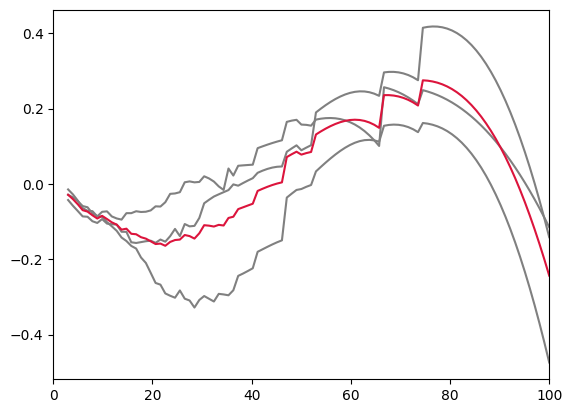

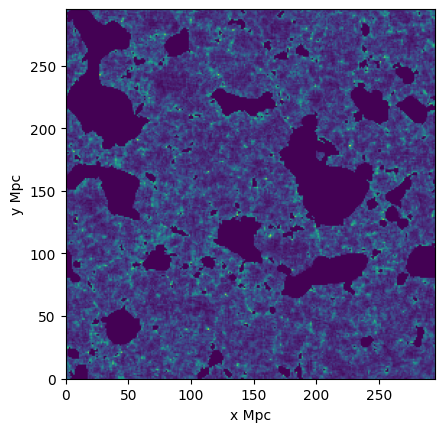

In [11]:
# for t in T:
#     plt.plot(r,t, color='gray')

# plt.plot(r, np.mean(T, axis=0), color='crimson')
# #plt.ylim(-0.2, 0.2)
# plt.xlim(0, 100)
# plt.show()

# with h5py.File(mock_h5, "r") as f:
#     slice2D = f['brightness_lightcone'][0, 0, :, :]

# L = 295
# plt.imshow(slice2D, extent=(0, L, 0, L))
# plt.xlabel('x Mpc')
# plt.ylabel('y Mpc')
# plt.show()

## Main function

In [12]:
# first attempt (simplest)

import time, h5py
from pathlib import Path

def run_all(
    simlist,
    *,
    tcf_code_dir,             # path to your TCF code dir
    z_indices=0,              # None = all; int or list ok
    nthreads=5,
    nbins=100,
    rmin=3,
    rmax=100,
    overwrite_h5=True,
    overwrite_txt=True,
    continue_on_error=False
):
    simlist = [Path(p).resolve() for p in simlist]

    t0_all = time.time()
    print(f"üöÄ Starting TCF run for {len(simlist)} sims\n")

    for s_idx, sim_path in enumerate(simlist, start=1):
        sim_name = sim_path.stem  # e.g. "Lightcone_FID_..."

        # the per-sim function will create: sim_path.parent / f"{sim_name}_txtfiles"
        expected_txt = sim_path.parent / f"{sim_name}_txtfiles"

        print(f"\n========== [{s_idx}/{len(simlist)}] {sim_name} ==========")
        print(f"H5:   {sim_path}")
        print(f"TXT:  {expected_txt}  (auto-created if needed)")

        t0 = time.time()
        try:
            compute_TCF_of_single_SIM_all_realisations(
                sim_filepath=sim_path,
                z_indices=z_indices,
                tcf_code_dir=tcf_code_dir,
                nthreads=nthreads,
                nbins=nbins,
                rmin=rmin,
                rmax=rmax,
                overwrite_h5=overwrite_h5,
                overwrite_txt=overwrite_txt,
                continue_on_error=continue_on_error,
            )
        except Exception as e:
            print(f"‚úó FAILED on {sim_name}: {e}")
            if not continue_on_error:
                raise
            continue

        # (optional) quick sanity: list newly written datasets
        try:
            with h5py.File(sim_path, "r") as f:
                keys = sorted(k for k in f.keys() if str(k).startswith("TCF_zidx"))
                preview = ", ".join(keys[:4]) + (" ..." if len(keys) > 4 else "")
                if keys:
                    print(f"   ‚úì Wrote datasets: {preview}")
                else:
                    print("   (no TCF_zidx* datasets found)")
        except Exception:
            pass

        print(f"‚è±  {sim_name} done in {time.time()-t0:.1f}s")

    print(f"\n‚úî All sims done in {time.time()-t0_all:.1f}s")


In [14]:
# example usage

# configure once
tcf_code_dir = "/home/lcrascal/Code/TCF/TCF_completed_code/TCF_required_files"

# your list of H5 files
mock_h5_1 = Path("/data/cluster/lcrascal/SIM_data/h5_files/mock_tests/Mock_SIM_1/Lightcone_MOCK_1.h5")
mock_h5_2 = Path("/data/cluster/lcrascal/SIM_data/h5_files/mock_tests/Mock_SIM_2/Lightcone_MOCK_2.h5")
simlist = [mock_h5_1, mock_h5_2]

# run (fast test config: 2 z-slices, fewer bins/threads)
run_all(
    simlist,
    tcf_code_dir=tcf_code_dir,
    z_indices=0,   # None for all
    nthreads=5,
    nbins=100,
    rmin=3,
    rmax=100,
    overwrite_h5=True,
    overwrite_txt=True,
    continue_on_error=False,
)


üöÄ Starting TCF run for 2 sims


========== [1/2] Lightcone_MOCK_1 ==========
H5:   /data/cluster/lcrascal/SIM_data/h5_files/mock_tests/Mock_SIM_1/Lightcone_MOCK_1.h5
TXT:  /data/cluster/lcrascal/SIM_data/h5_files/mock_tests/Mock_SIM_1/Lightcone_MOCK_1_txtfiles  (auto-created if needed)
üìÇ TXT files will be stored in: /data/cluster/lcrascal/SIM_data/h5_files/mock_tests/Mock_SIM_1/Lightcone_MOCK_1_txtfiles
L: 295.24653085326247
DIM: 256
üìÇ Extracting slices to .txt files...

Extracting slices for z_idx=0 -> /data/cluster/lcrascal/SIM_data/h5_files/mock_tests/Mock_SIM_1/Lightcone_MOCK_1_txtfiles/Lightcone_zidx0
  ‚úî Saved 3 slice(s) for z_idx=0
‚ñ∂ z_idx 0 (1/1) ‚Üí /data/cluster/lcrascal/SIM_data/h5_files/mock_tests/Mock_SIM_1/Lightcone_MOCK_1_txtfiles/Lightcone_zidx0
 Found 3 realisations
   Overwriting existing dataset TCF_zidx0
      ‚Üí Starting Realisation 1/3: realisation_0.txt  (start: 2025-09-16 15:32:11)
Updating SC.h with absolute path: /data/cluster/lcrascal/SIM_data/h

TCF_zidx0: shape=(3, 100), TCF_zidx0_rvals: shape=(100,)
  sample row stats: min=-0.115 max=0.257
  r range: [3, 100]


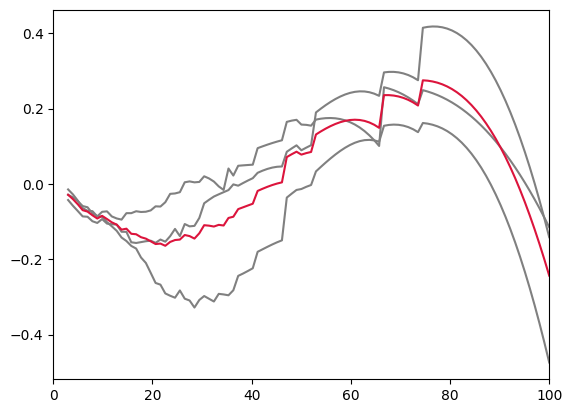

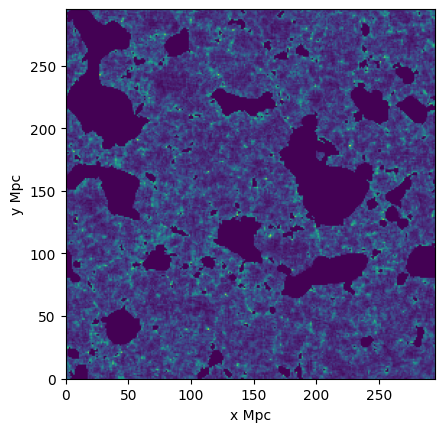

In [15]:

# chcek contents of h5 files

z_to_test = [0]
nbins_test = 100
# --- verify outputs exist and have correct shapes ---
mock_h5 = mock_h5_1 # check either file 1 or 2
#mock_h5 = mock_h5_2

with h5py.File(mock_h5, "r") as f:
    # discover n_realisations from the source dataset
    n_real = f["brightness_lightcone"].shape[0]

    for z in z_to_test:
        ds_TCF = f"TCF_zidx{z}"
        ds_r   = f"{ds_TCF}_rvals"
        assert ds_TCF in f, f"Missing dataset {ds_TCF}"
        assert ds_r   in f, f"Missing dataset {ds_r}"

        T = f[ds_TCF][...]     # shape: (n_realisations, nbins)
        r = f[ds_r][...]       # shape: (nbins,)
        print(f"{ds_TCF}: shape={T.shape}, {ds_r}: shape={r.shape}")

        # shape checks
        assert T.shape[0] == n_real, f"Row count mismatch ({T.shape[0]} vs {n_real})"
        assert T.shape[1] == nbins_test, f"nbins mismatch ({T.shape[1]} vs {nbins_test})"
        assert r.shape[0] == nbins_test, "r grid length mismatch"

        # quick content sanity (not all zeros / NaNs)
        print("  sample row stats: min={:.3g} max={:.3g}".format(np.nanmin(T[0]), np.nanmax(T[0])))
        print("  r range: [{:.3g}, {:.3g}]".format(float(r.min()), float(r.max())))

# plots
for t in T:
    plt.plot(r,t, color='gray')

plt.plot(r, np.mean(T, axis=0), color='crimson')
#plt.ylim(-0.2, 0.2)
plt.xlim(0, 100)
plt.show()

with h5py.File(mock_h5, "r") as f:
    slice2D = f['brightness_lightcone'][0, 0, :, :]

L = 295
plt.imshow(slice2D, extent=(0, L, 0, L))
plt.xlabel('x Mpc')
plt.ylabel('y Mpc')
plt.show()        

## misc

In [ ]:
# second attempt (more complex, with noise)

for sim in simlist

    compute TCF of single sim all realisations
        - this will extract the realisations as txt files
        - compute the TCF of each realisation
        - save results back into sim fh5 file



In [3]:
mock_h5_1 = Path("/data/cluster/lcrascal/SIM_data/h5_files/mock_tests/Lightcone_MOCK_1.h5")


sim_filepath = Path(mock_h5_1).resolve()
sim_dir = sim_filepath.parent
sim_stem = sim_filepath.stem
txt_root = sim_dir / f"{sim_stem}_txtfiles"
#txt_root.mkdir(parents=True, exist_ok=True)

print(sim_filepath)
print(sim_dir)
print(sim_stem)
print(txt_root)


/data/cluster/lcrascal/SIM_data/h5_files/mock_tests/Lightcone_MOCK_1.h5
/data/cluster/lcrascal/SIM_data/h5_files/mock_tests
Lightcone_MOCK_1
/data/cluster/lcrascal/SIM_data/h5_files/mock_tests/Lightcone_MOCK_1_txtfiles


In [18]:
print((2/np.sqrt(3))*30)

34.64101615137755
